# Mortality prediction post micro-biology result patients using EHR data with no QC - XGBoost

## Read data matrix

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_micro.data_matrix_no_qc;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,bicarbonate_first,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last
0,9769904,-1046091425,0,0,0,0,0,0,0,0,...,0.232437,0.672591,-0.826453,-0.056485,-0.213440,-0.772442,-0.615576,0.046775,0.382481,-0.710177
1,2985612,697543230,0,0,0,0,0,0,0,0,...,-0.905166,-1.303816,-0.686594,-1.608937,1.859297,-0.344966,1.088720,-0.718203,0.323023,-0.496477
2,2871076,428913244,0,0,0,0,0,0,0,0,...,0.232437,-0.391629,-0.686594,-0.746464,1.119034,-0.772442,0.899354,0.429265,2.701327,-0.638943
3,6894504,-1600246244,0,0,0,0,1,1,1,0,...,-0.146764,0.723268,-0.756523,0.978483,-0.657598,-0.307794,-0.236844,0.429265,1.095972,-0.781410
4,8752252,431197671,1,1,1,1,1,1,1,0,...,1.370041,-0.695691,-0.406877,-0.573969,0.526823,-0.995473,0.331255,0.238020,-0.509383,-0.710177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7334,1866973,2023686478,0,0,0,0,0,0,0,0,...,-1.094767,-0.645014,1.061635,-1.091453,1.711244,-0.177693,1.088720,-0.909448,-0.509383,-0.069076
7335,2124103,2023686478,0,0,0,0,0,0,0,0,...,0.422038,0.368528,-0.966311,-0.918959,0.526823,-0.475067,-0.047477,-0.144469,0.382481,-0.923877
7336,5256383,2023686478,0,0,0,0,0,0,0,0,...,-1.094767,0.925976,0.711990,0.978483,-0.805651,-0.921129,-0.426210,0.238020,0.441938,0.073391
7337,2268946,1484033855,0,0,0,0,0,0,0,0,...,0.801239,-0.391629,-0.826453,-0.401475,0.822928,-0.456481,0.709987,1.385488,-0.212095,-0.638943


## Test/Train split

In [2]:
X = dataDf.drop(['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality', 'ninety_day_mortality', 'onetwenty_day_mortality'], axis = 1)
y_seven_day = dataDf['seven_day_mortality']
y_fourteen_day = dataDf['fourteen_day_mortality']
y_twentyone_day = dataDf['twentyone_day_mortality']
y_twentyeight_day = dataDf['twentyeight_day_mortality']
y_sixty_day = dataDf['sixty_day_mortality']
y_ninety_day = dataDf['ninety_day_mortality']
y_onetwenty_day = dataDf['onetwenty_day_mortality']

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_seven_day_train, y_seven_day_test, y_fourteen_day_train, y_fourteen_day_test, y_twentyone_day_train, y_twentyone_day_test, y_twentyeight_day_train, y_twentyeight_day_test, y_sixty_day_train, y_sixty_day_test, y_ninety_day_train, y_ninety_day_test, y_onetwenty_day_train, y_onetwenty_day_test = train_test_split(X, y_seven_day, y_fourteen_day, y_twentyone_day, y_twentyeight_day, y_sixty_day, y_ninety_day, y_onetwenty_day, test_size=0.2, random_state=42)

In [4]:
X_train.shape, X_test.shape

((5871, 158), (1468, 158))

In [6]:
y_seven_day_train.shape, y_seven_day_test.shape

((5871,), (1468,))

In [7]:
y_fourteen_day_train.shape, y_fourteen_day_test.shape

((5871,), (1468,))

In [8]:
y_twentyone_day_train.shape, y_twentyone_day_test.shape

((5871,), (1468,))

In [9]:
y_twentyeight_day_train.shape, y_twentyeight_day_test.shape

((5871,), (1468,))

In [10]:
y_sixty_day_train.shape, y_sixty_day_test.shape

((5871,), (1468,))

In [11]:
y_ninety_day_train.shape, y_ninety_day_test.shape

((5871,), (1468,))

In [12]:
y_onetwenty_day_train.shape, y_onetwenty_day_test.shape

((5871,), (1468,))

## Machine Learning using XGBoost

In [13]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Seven-day mortality prediction

In [14]:
xgb_seven_day = XGBClassifier()
xgb_seven_day.fit(X_train, y_seven_day_train)
y_seven_day_pred = xgb_seven_day.predict(X_test)
y_seven_day_prob = xgb_seven_day.predict_proba(X_test)

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:37:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<BarContainer object of 142 artists>

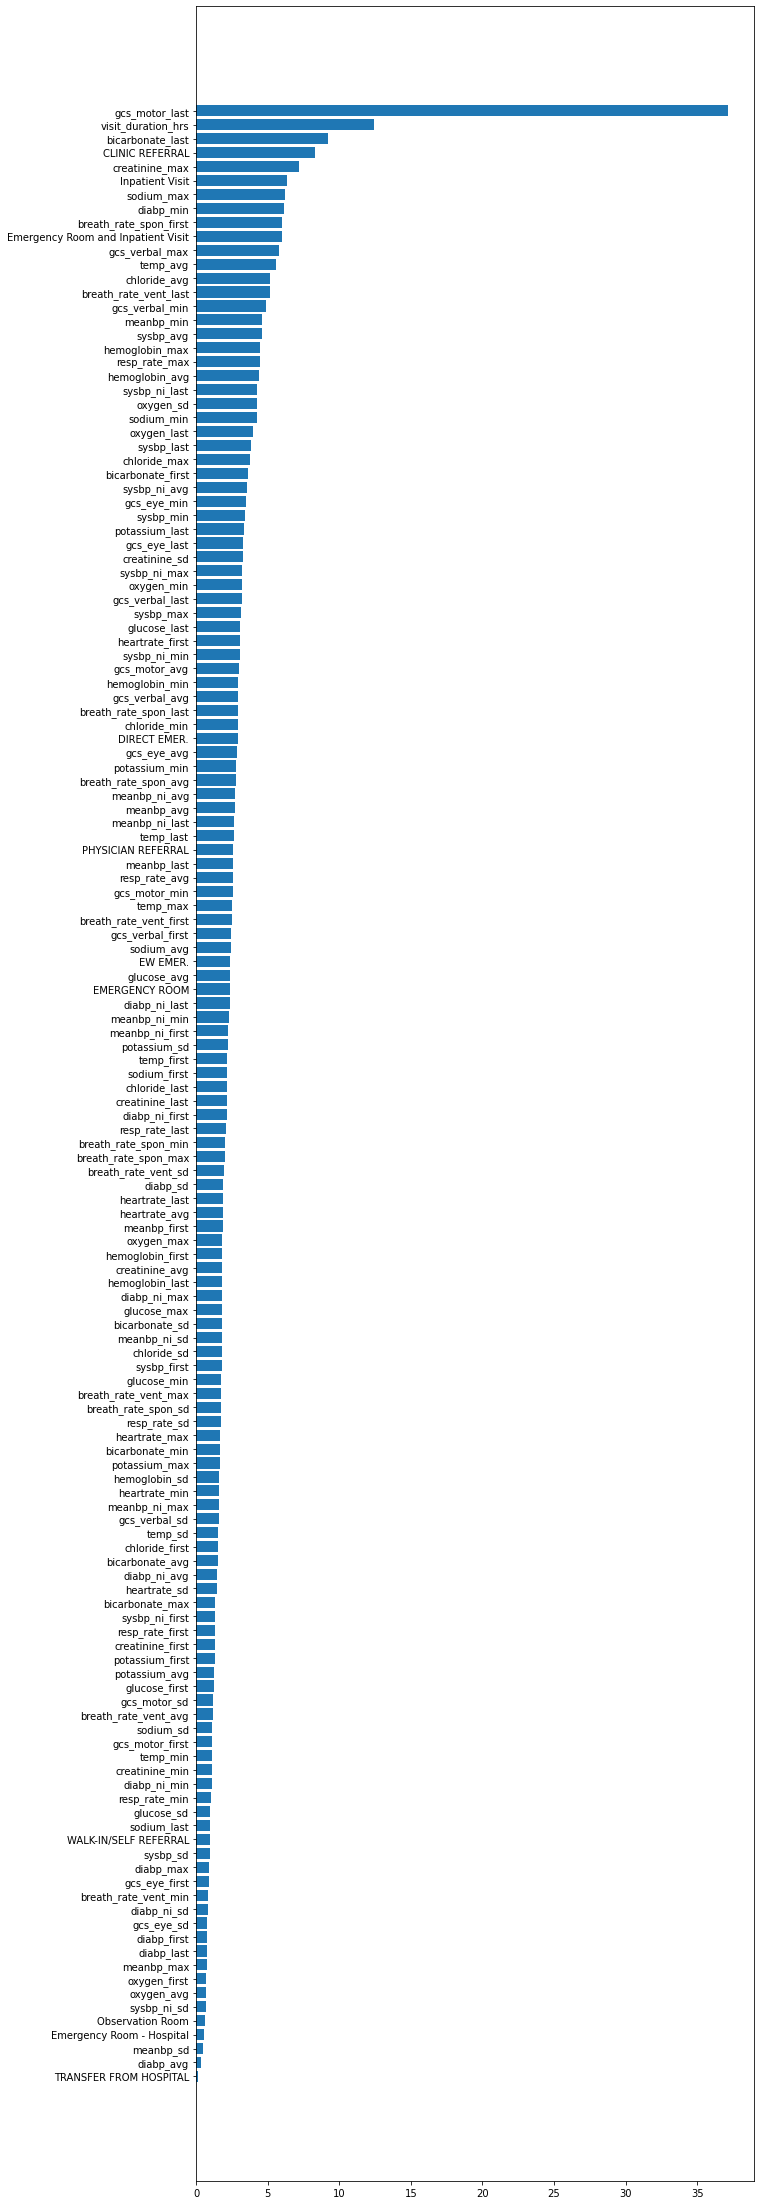

In [15]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb_seven_day.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

### Performance metrics

#### Accuracy

In [16]:
from sklearn.metrics import accuracy_score

print('Seven-day mortality accuracy: ', str(accuracy_score(y_seven_day_pred, y_seven_day_test)))

Seven-day mortality accuracy:  0.9693460490463215
